In [1]:
import numpy as np
import os
import shutil
import json
import pandas as pd

In [2]:
# Prepare the data
data_folder = '../data'
image_formats = ['.jpg', '.jpeg', '.png', '.bmp']
output_folder = os.path.join(data_folder, '_preped')
os.makedirs(output_folder, exist_ok=True)

for foldername in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, foldername)
    if os.path.isdir(folder_path) and foldername != '_preped':
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                name, extension = os.path.splitext(filename)
                if extension in image_formats:
                    new_filename = f"{foldername}_{name}{extension}"
                    new_file_path = os.path.join(output_folder, new_filename)
                    shutil.copy2(file_path, new_file_path)

In [3]:
label_file = ''
# Create labels folder and save modified JSON
labels_folder = '../data/_labels'
os.makedirs(labels_folder, exist_ok=True)
for foldername in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, foldername)
    if os.path.isdir(folder_path) and foldername != '_labels': 
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                name, extension = os.path.splitext(filename)
                if extension == '.json':
                    label_file = file_path
                    break
                else:
                    label_file = 'not found'
        if label_file == 'not found':
            print(f"No label file found in folder: {foldername}")
            continue

        print(f"Label file found: {label_file}")
        with open(label_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

        cnt = 0
        # Process each entry
        for entry in data:
            if 'file_upload' in entry:
                # Remove labelstudio hash prefix
                parts = entry['file_upload'].split('-', 1)  # Split only on first '-'
                if len(parts) > 1:
                    entry['file_upload'] = f"{foldername}_{parts[1]}"
                    cnt += 1

        # Get original filename and create new path
        original_filename = os.path.basename(label_file)
        new_label_path = os.path.join(labels_folder, original_filename)

        # Save the modified JSON
        with open(new_label_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"Total entries updated: {cnt}")

Label file found: ../data\B8V41Y\b8v41y.json
Total entries updated: 20
Label file found: ../data\C6037J\C6037J.json
Total entries updated: 34
Label file found: ../data\consensus\b8v41y.json
Total entries updated: 57
Label file found: ../data\D6AE9F\D6AE9F.json
Total entries updated: 22
No label file found in folder: ECSGGY
Label file found: ../data\FGWUFP\FGWUFP.json
Total entries updated: 20
Label file found: ../data\FO6K58\FO6K58_labels.json
Total entries updated: 32
No label file found in folder: GI9Y8B
Label file found: ../data\GK1XQ4\project-1-at-2025-10-15-23-46-9d203653.json
Total entries updated: 52
Label file found: ../data\H51B9J\H51B9J.json
Total entries updated: 23
Label file found: ../data\ITWQ3V\ITWQ3V.json
Total entries updated: 23
Label file found: ../data\NC1O2T\hf_labels_export.json
Total entries updated: 20
Label file found: ../data\NX9GA4\NX9GA4_ankles_labeled.json
Total entries updated: 20
Label file found: ../data\ODZF0M\project-2-at-2025-10-16-02-08-8ee4fdfa.json

In [4]:
#Match the file names with the labels
image_names = list(os.listdir(output_folder))
data_ready = []
for label_filename in os.listdir(labels_folder):
    label_path = os.path.join(labels_folder, label_filename)
    with open(label_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)
    for entry in labels:
        if 'file_upload' in entry:
            if entry['file_upload'] in image_names:
                result = entry['annotations'][0].get('result')
                if len(result) > 0:
                    label = result[0].get('value').get('choices')[0]
                    data_ready.append((entry['file_upload'], label))
print(f"Total matched entries: {len(data_ready)}")

Total matched entries: 242


In [5]:
# Reaname the 3 wrong labels:
for i in range(len(data_ready)):
    imge_name, label = data_ready[i]
    if label == 'neutral': data_ready[i] = (imge_name, '2_Neutralis')
    elif label == 'pronation': data_ready[i] = (imge_name, '1_Pronacio')
    elif label == 'supination': data_ready[i] = (imge_name, '3_Szupinacio')

# Get the majority class
labels = [label for _, label in data_ready]

unique_labels, counts = np.unique(labels, return_counts=True)
majority_class = unique_labels[np.argmax(counts)]
print(f"Majority class: {majority_class}")

Majority class: 1_Pronacio


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Baseline: Always predict the majority class
def baseline_predict(data):
    return [majority_class] * len(data)

# Evaluate baseline accuracy
true_labels = labels
predicted_labels = baseline_predict(data_ready)
accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Baseline accuracy: {accuracy * 100:.2f}%")
print(f"Baseline precision: {precision * 100:.2f}%")
print(f"Baseline recall: {recall * 100:.2f}%")
print(f"Baseline F1-score: {f1 * 100:.2f}%")

# For detailed per-class metrics
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels))


Baseline accuracy: 43.39%
Baseline precision: 18.83%
Baseline recall: 43.39%
Baseline F1-score: 26.26%

Detailed Classification Report:
              precision    recall  f1-score   support

  1_Pronacio       0.43      1.00      0.61       105
 2_Neutralis       0.00      0.00      0.00        98
3_Szupinacio       0.00      0.00      0.00        39

    accuracy                           0.43       242
   macro avg       0.14      0.33      0.20       242
weighted avg       0.19      0.43      0.26       242



c:\Users\Asus\anaconda3\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\anaconda3\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\anaconda3\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [7]:
from collections import Counter

# Read what picture are in consensus text file
consensus_file_path =  os.path.join(data_folder, 'consensus')
consensus_file = os.path.join(consensus_file_path, 'anklealign-consensus.txt')
with open(consensus_file, 'r', encoding='utf-8') as f:
    consensus_images = f.read().splitlines()

img_names = []
# Get every image name from the consensus file
for img in consensus_images:
    parts = img.split('\\')
    if len(parts) > 1:
        img_names.append(parts[-1])

# Count occurrences of each image name
img_counts = Counter(img_names)

# Keep only images that appear exactly once
unique_consensus_image_names = [img for img, count in img_counts.items() if count == 1]

print(f"Total images in consensus: {len(img_names)}")
print(f"Unique images (appearing exactly once): {len(unique_consensus_image_names)}")
print(f"Duplicate images removed: {len(img_names) - len(unique_consensus_image_names)}")

Total images in consensus: 57
Unique images (appearing exactly once): 49
Duplicate images removed: 8


In [8]:
consensus_label_matrix = pd.DataFrame({
    'image': unique_consensus_image_names,
    'pronation': 0,
    'neutral': 0,
    'supination': 0
})

for consensus_label_file in os.listdir(consensus_file_path):
    extension = os.path.splitext(consensus_label_file)[1]
    consensus_label_path = os.path.join(consensus_file_path, consensus_label_file)
    if extension != '.json' or os.path.getsize(consensus_label_path) == 0:
        continue

    with open(consensus_label_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)
    for entry in labels:
        if 'file_upload' in entry:
            img_name = entry['file_upload'].split('-', 1)[1]  # Remove hash prefix
            if img_name in unique_consensus_image_names:
                result = entry['annotations'][0].get('result')
                if len(result) > 0:
                    label = result[0].get('value').get('choices')[0]
                    if label == '1_Pronacio':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, 'pronation'] += 1
                    elif label == '2_Neutralis':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, 'neutral'] += 1
                    elif label == '3_Szupinacio':
                        consensus_label_matrix.loc[consensus_label_matrix['image'] == img_name, 'supination'] += 1

In [9]:
unique_consensus_images = []

# Rename the images as the prepared data
for img in consensus_images:
    parts = img.split('\\')
    if len(parts) > 1 and parts[2] in unique_consensus_image_names:
        label = np.argmax([consensus_label_matrix.loc[consensus_label_matrix['image'] == parts[2], 'pronation'].values[0],
                         consensus_label_matrix.loc[consensus_label_matrix['image'] == parts[2], 'neutral'].values[0],
                         consensus_label_matrix.loc[consensus_label_matrix['image'] == parts[2], 'supination'].values[0]])
        unique_consensus_images.append((f"{parts[1]}_{parts[2]}", label))
print(len(unique_consensus_images))

49


In [10]:
# Match the consensus images with the prepared data
matched_consensus = []
for img, _ in unique_consensus_images:
    for data_img, _ in data_ready:
        if img == data_img:
            matched_consensus.append((data_img))

train_data = [(img, label) for img, label in data_ready if img not in matched_consensus]
test_data = unique_consensus_images


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

torch.cuda.is_available()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to consistent size
    transforms.ToTensor(),           # Convert to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

x_train = []
y_train = []

for img_name, label in train_data:
    img_path = os.path.join(output_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_train.append(img_tensor)
        y_train.append(label)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

# Stack into tensors
x_train_tensor = torch.stack(x_train)
print(f"Training images shape: {x_train_tensor.shape}")

# Encode labels to integers
label_to_idx = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_encoded = [label_to_idx[label] for label in y_train]
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Label mapping: {label_to_idx}")

In [ ]:
x_test = []
y_test = []

for img_name, label in test_data:
    img_path = os.path.join(output_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_test.append(img_tensor)
        y_test.append(label)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

x_test_tensor = torch.stack(x_test)
print(f"Test images shape: {x_test_tensor.shape}")
y_test_encoded = [label_to_idx[label] for label in y_test]
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

print(f"Test labels shape: {y_test_tensor.shape}")

In [ ]:
batch_size = 32
num_epochs = 15
lr = 0.001
device = 'cpu' 

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 56x56 -> 28x28
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)

In [19]:
from tqdm.auto import tqdm
torch.cuda.empty_cache()

loss_values = []

net1.train()
for epoch in tqdm(range(num_epochs), desc='Training model'):
    epoch_loss = 0.0
    num_batches = 0
    for images, target_labels in train_loader:
        images = images.to(device)
        target_labels = target_labels.to(device)

        pred_logits = net1(images)
        loss = loss_fn(pred_logits, target_labels)
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_epoch_loss = epoch_loss / num_batches
    loss_values.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

Training model:   7%|▋         | 1/15 [00:03<00:49,  3.51s/it]

Epoch 1/15, Average Loss: 1.0551


Training model:  13%|█▎        | 2/15 [00:06<00:43,  3.35s/it]

Epoch 2/15, Average Loss: 1.0151


Training model:  20%|██        | 3/15 [00:10<00:41,  3.44s/it]

Epoch 3/15, Average Loss: 0.9531


Training model:  27%|██▋       | 4/15 [00:13<00:37,  3.43s/it]

Epoch 4/15, Average Loss: 0.8572


Training model:  33%|███▎      | 5/15 [00:16<00:33,  3.38s/it]

Epoch 5/15, Average Loss: 0.7923


Training model:  40%|████      | 6/15 [00:20<00:30,  3.34s/it]

Epoch 6/15, Average Loss: 0.6761


Training model:  47%|████▋     | 7/15 [00:23<00:26,  3.31s/it]

Epoch 7/15, Average Loss: 0.6261


Training model:  53%|█████▎    | 8/15 [00:26<00:22,  3.28s/it]

Epoch 8/15, Average Loss: 0.4701


Training model:  60%|██████    | 9/15 [00:29<00:19,  3.27s/it]

Epoch 9/15, Average Loss: 0.4103


Training model:  67%|██████▋   | 10/15 [00:33<00:16,  3.25s/it]

Epoch 10/15, Average Loss: 0.2132


Training model:  73%|███████▎  | 11/15 [00:36<00:12,  3.20s/it]

Epoch 11/15, Average Loss: 0.1633


Training model:  80%|████████  | 12/15 [00:39<00:09,  3.18s/it]

Epoch 12/15, Average Loss: 0.2747


Training model:  87%|████████▋ | 13/15 [00:42<00:06,  3.21s/it]

Epoch 13/15, Average Loss: 0.1572


Training model:  93%|█████████▎| 14/15 [00:45<00:03,  3.21s/it]

Epoch 14/15, Average Loss: 0.1164


Training model: 100%|██████████| 15/15 [00:49<00:00,  3.27s/it]

Epoch 15/15, Average Loss: 0.0826


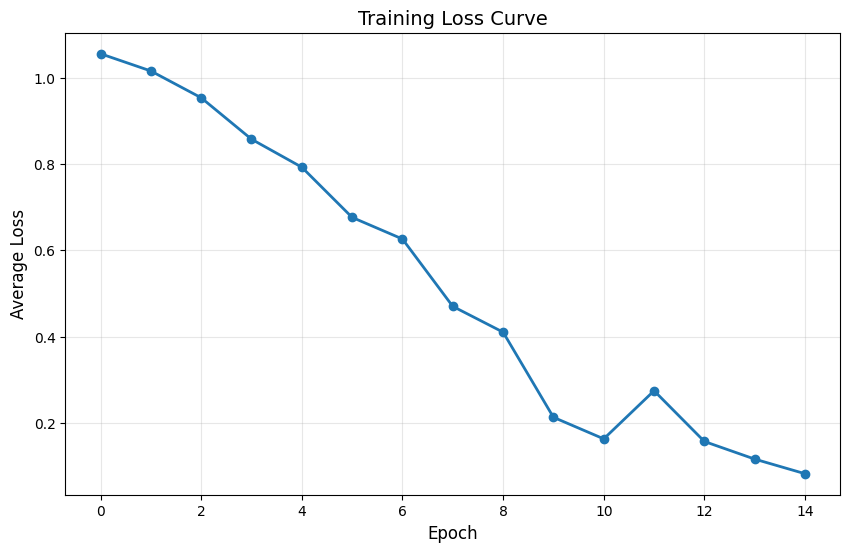

[1.0550604632922582, 1.0151289020265852, 0.9531303559030805, 0.8571592995098659, 0.7923085859843663, 0.6760920456477574, 0.6260636406285423, 0.47006995337350027, 0.4103323646954128, 0.21324493629591806, 0.16329299126352584, 0.27472010999917984, 0.15722489144120896, 0.11640818629946027, 0.08258848025330476]


In [20]:
# Plot training loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(loss_values)

In [21]:
# Training score
true_labels = y_train_encoded
predicted_labels = []
net1.eval()
with torch.no_grad():
    # Create a new loader WITHOUT shuffle for evaluation
    eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    for images, _ in eval_loader:
        images = images.to(device)
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"1st network accuracy: {accuracy * 100:.2f}%")
print(f"1st network precision: {precision * 100:.2f}%")
print(f"1st network recall: {recall * 100:.2f}%")
print(f"1st network F1 score: {f1 * 100:.2f}%")

print(classification_report(true_labels, predicted_labels))

1st network accuracy: 98.17%
1st network precision: 98.22%
1st network recall: 98.17%
1st network F1 score: 98.18%
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       105
           1       0.97      1.00      0.99        78
           2       0.95      0.97      0.96        36

    accuracy                           0.98       219
   macro avg       0.97      0.98      0.98       219
weighted avg       0.98      0.98      0.98       219

